# Goal<br>
* Develop a machine learning model using bag of words and vectorization that will take in Netflix descriptions of shows in it's database and predict wether the show matching each discription belongs to a given genre<br>

* Inestigate wether this technique can be inhanced by identifying "unique words," words that only occur in discriptions belonging to that genre

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e

# Wrangle

Data acquired from kaggle 
Each represints a show featured by Netflix

Columns not representing show descriptions or genres were dropped
A boolean column for each genre appearing in the "genres" column was added signifying if each show belonged to that genre

Rows containning blank descriptions were dropped
'Western' column was dropped do to low represintation (only 41 rows)

Data contains 5791 rows after being prepared 

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# get set of non-western genres
gen_set = e.get_gens(train)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")

# getting exploration variables

# gets dictionaries 
# containing word, relative requency of apearance in comedy and non-comedy films by count and by document count 
# and a list for each containing frequency numbers only
freq_doc, freq_count, list_freq_doc, list_freq_count = e.get_majoriety_counts(train)

Train set contains 3242 rows of data


Getting exploration variables

# Explore

**1) Investigate data and choose a genre as a test case**

   * Test case should have a large represintation in the data
   * Test case should have a large number of unique words
   * Test case should have a large number of unique words per document

**How many shows are there of each genre?**

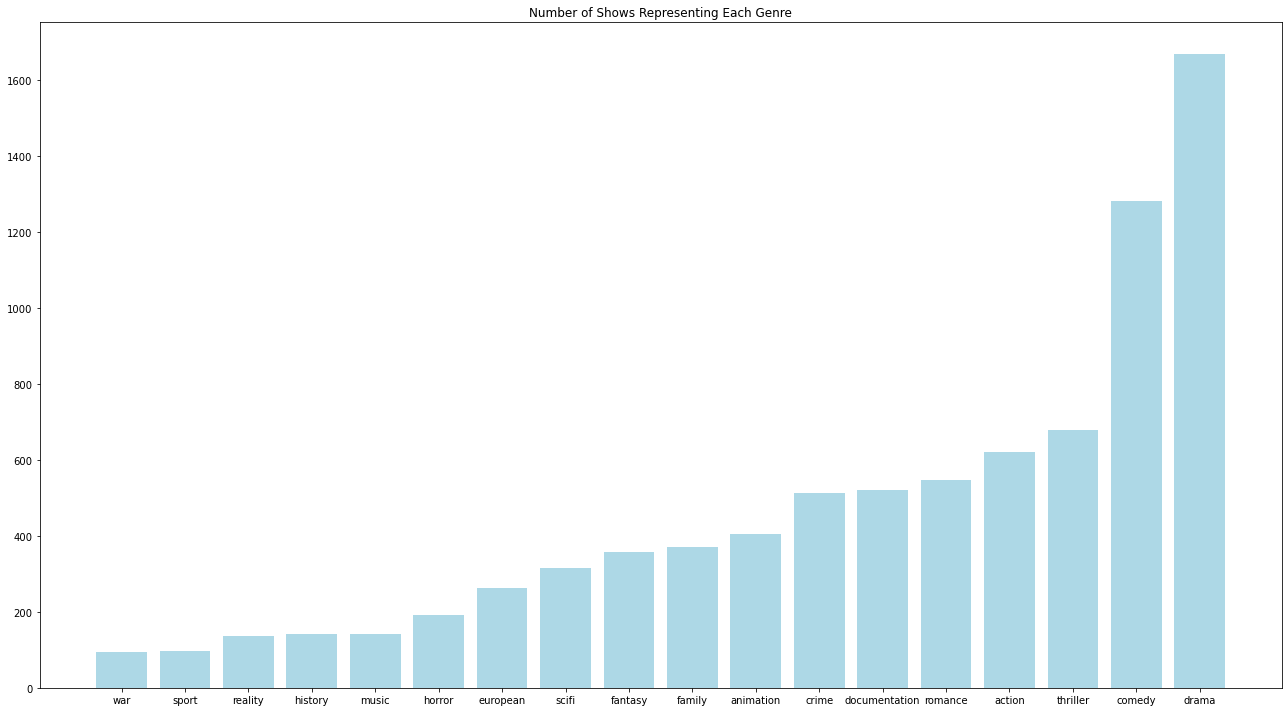

In [3]:
# get distribution of genres
e.shows_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners.

**How many words in each genre are unique words? (Appear only in descriptions of movies of that fall under that genre)**

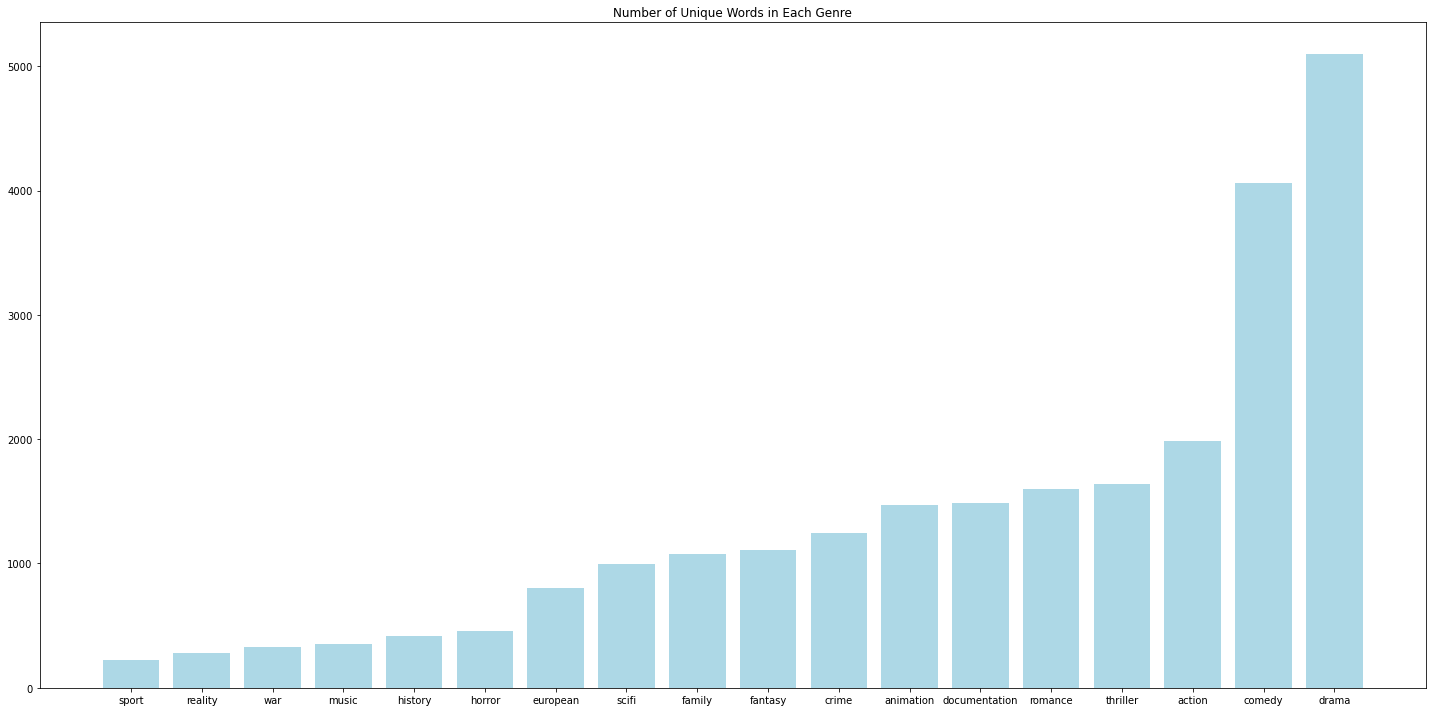

In [4]:
# get number of unique words fro each genre
e.unique_words_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners for unique words as well.

**How fequently do unique words appear in each genre?**

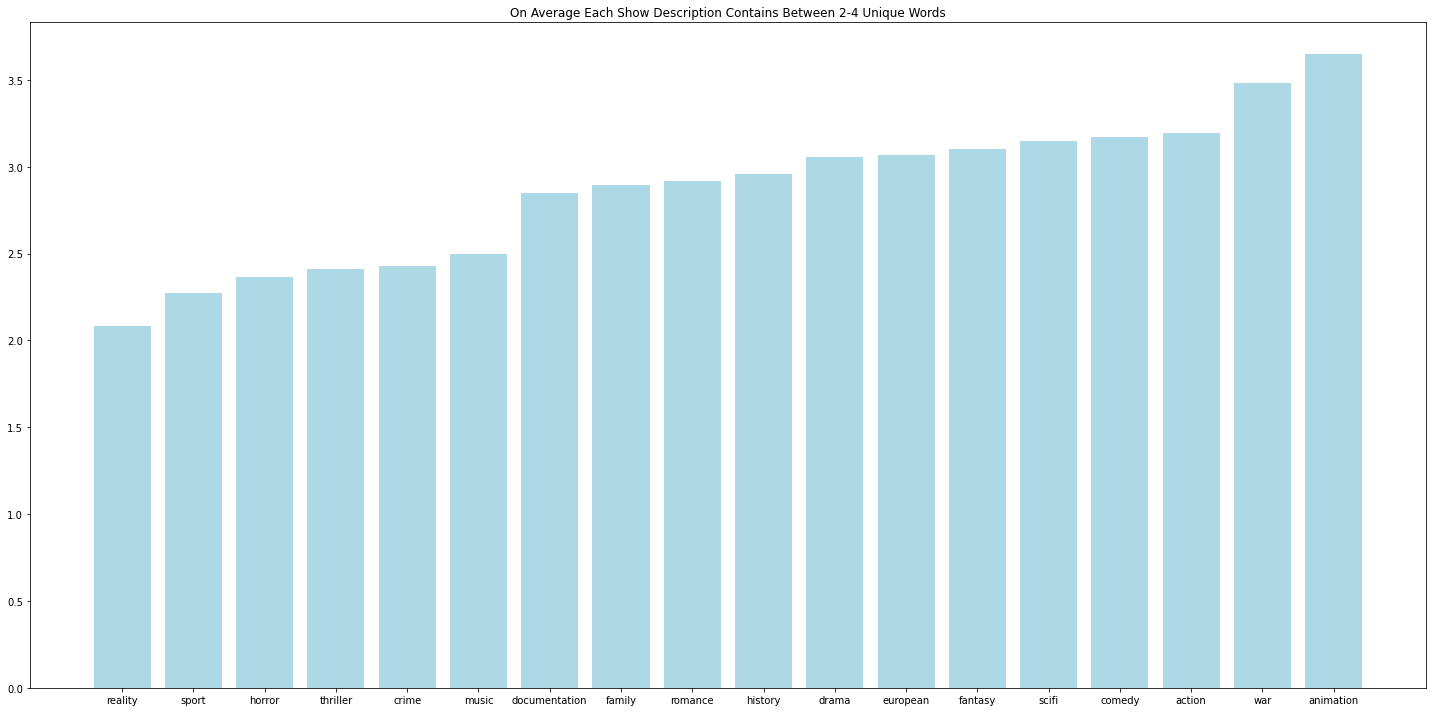

In [5]:
# get frequency of unique words pre genre
e.unique_words_frequency(train, gen_set)

Not a great deal of variance in unique word frequency. Comedy and Drama both have grater than three they were front runners in the other two criteria

**Comedy** and **Drama** have consistantly high values in all test criteria.
Comedy seems the less vague of the two genres, by human understanding. I will choose **Comedy** as my test case.

**2) Investigate test case (Comedy) and see how it compares to the rest of the data**

* What percent of the data is classified as a Comedy?
* Are there any words that appear more or less frequently across comedy or non-comedy show descriptions? <br>(Overall/by document)

**How much of the data is Comedy?**

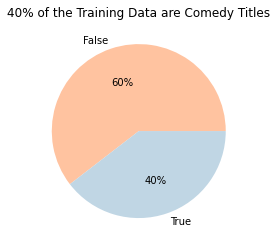

In [6]:
e.omni_pie(train.comedy, "40% of the Training Data are Comedy Titles")

The following chart shows a count of the relative document frequency of each unique word that appears in descriptions in the training data. <br>
The number is calculated in the following way: <br>
number of comedy documents the word appears in minus the number of non-comedy documents the word appears in

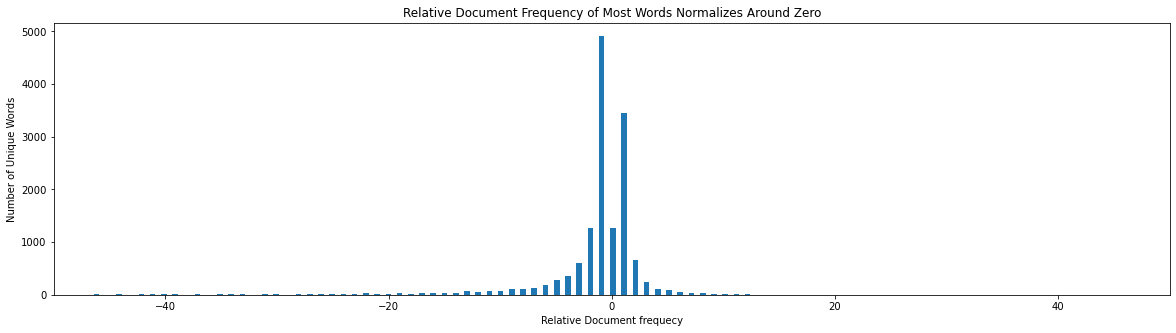

In [7]:
e.get_hist_doc(list_freq_doc)

* Words that have do not have a significant difference in the number of documents they appear in for comedy and non-comedy films will not be useful in guiding the model
* This distribution suggests that there are a lot of words that are not helpful to the model
* Removing these words from the final model will eliminate noise and hopefully lead to improved model performance

The following chart shows a count of the relative word frequency of each unique word that appears in descriptions in the training data. <br>
The number is calculated in the following way: <br>
number of times the word appears in comedy documents minus number of times the word appears in non-comedy documents

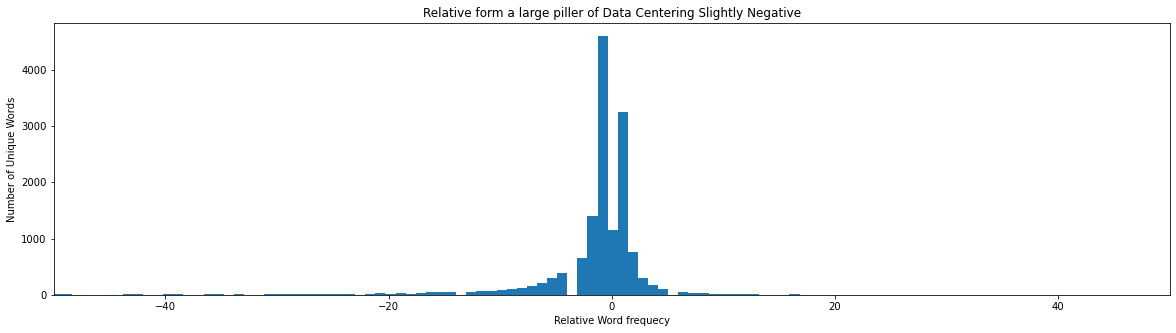

In [8]:
e.get_hist_word(list_freq_count)

* As with document frequency it may be helpful to eleminate words that do not appear a significantly differint number of times in comedy and non-comedy films

In [12]:
print(freq_doc)

[('ing', -395), ('tio', -227), ('con', -219), ('man', -202), ('est', -191), ('life', -168), ('men', -165), ('ted', -163), ('tory', -155), ('story', -154), ('eat', -148), ('ill', -147), ('per', -146), ('eve', -142), ('ali', -136), ('sti', -136), ('doc', -134), ('art', -134), ('world', -134), ('young', -130), ('ice', -128), ('tin', -128), ('son', -127), ('red', -127), ('one', -126), ('pro', -122), ('dea', -121), ('lit', -117), ('year', -115), ('den', -109), ('lea', -106), ('war', -100), ('min', -100), ('par', -99), ('age', -97), ('led', -97), ('old', -96), ('rim', -94), ('lin', -93), ('cum', -92), ('king', -90), ('murder', -88), ('anc', -87), ('kill', -87), ('dent', -85), ('see', -83), ('ting', -83), ('ring', -82), ('rin', -82), ('cover', -80), ('document', -80), ('series', -79), ('even', -79), ('use', -78), ('gen', -78), ('cha', -77), ('mat', -76), ('ned', -76), ('han', -75), ('try', -75), ('documentary', -72), ('chi', -72), ('sid', -71), ('sol', -70), ('sin', -70), ('side', -70), ('fin

In [10]:
freq_count

[('ing', -785),
 ('tio', -301),
 ('con', -263),
 ('man', -262),
 ('est', -238),
 ('men', -200),
 ('tory', -191),
 ('ted', -185),
 ('ill', -185),
 ('story', -182),
 ('life', -178),
 ('per', -174),
 ('eat', -169),
 ('eve', -164),
 ('ali', -157),
 ('son', -156),
 ('ice', -155),
 ('world', -150),
 ('red', -149),
 ('sti', -147),
 ('young', -142),
 ('doc', -140),
 ('den', -139),
 ('pro', -139),
 ('one', -133),
 ('dea', -132),
 ('lit', -131),
 ('art', -130),
 ('year', -129),
 ('tin', -126),
 ('age', -124),
 ('lea', -118),
 ('old', -114),
 ('par', -107),
 ('led', -106),
 ('war', -105),
 ('rim', -104),
 ('anc', -104),
 ('rin', -104),
 ('min', -101),
 ('king', -99),
 ('kill', -98),
 ('dent', -96),
 ('chi', -96),
 ('use', -95),
 ('cum', -94),
 ('murder', -93),
 ('lin', -93),
 ('mat', -93),
 ('cha', -93),
 ('cover', -91),
 ('ring', -90),
 ('see', -90),
 ('gen', -89),
 ('even', -86),
 ('fin', -86),
 ('han', -85),
 ('try', -82),
 ('document', -81),
 ('side', -81),
 ('sin', -79),
 ('sea', -78),
 ('ti

In [11]:
freq_doc = dict(sorted(my_dict.items(), key=lambda x: x[1]))

print(sorted_dict)

NameError: name 'my_dict' is not defined

In [ ]:
freq_doc = {key: value for key, value in freq_doc.items() if len(key) >= 3}

freq_doc

In [ ]:
train_set_of_words = set(train['description'].apply(lambda value : value.split(' '))
                                                 .explode('description')
                                                 .to_list())

comedy_word_list = train['description'][train.comedy == True].apply(lambda value : value.split(' ')).explode('description').to_list()
print("com words", len(comedy_word_list))

non_comedy_word_list = train['description'][train.comedy == False].apply(lambda value : value.split(' ')).explode('description').to_list()
print("non-com words", len(non_comedy_word_list))

In [ ]:
diff_list = []

word_rel_freq = {} 



In [ ]:
len(comedy_train)

In [ ]:
freq_doc = {}
freq_count = {}

list_freq_doc = []
list_freq_count = []

train_set_of_words = set(train['description'].apply(lambda value : value.split(' '))
                                                 .explode('description')
                                                 .to_list())

comedy_train = train[train.comedy == True]

non_comedy_train = train[train.comedy == False]

In [ ]:
for word in train_set_of_words:

        # get count of comedy films that have word in them
        comedy_train['com_count'] = comedy_train['description'].apply(lambda words: words.count(word))
        
        comedy_train['com_doc'] = comedy_train['com_count'] > 0
        
        c_w_count = comedy_train['com_count'].sum()
        
        c_d_count = comedy_train['com_doc'].sum()
        
        # get count of non-comedy films that have word in them
        non_comedy_train['non_count'] = non_comedy_train['description'].apply(lambda words: words.count(word))
        
        non_comedy_train['non_doc'] = non_comedy_train['non_count'] > 0
        
        n_w_count = non_comedy_train['non_count'].sum()
        
        n_d_count = non_comedy_train['non_doc'].sum()
        
        # subtract number of non-comedy films from number of comedy films
        
        w_total = c_w_count - n_w_count
        
        d_total = c_d_count - n_d_count
        
        # append difference
        
        freq_doc[f'{word}'] = d_total
        
        list_freq_doc.append(d_total)
        
        freq_count[f'{word}'] = w_total
        
        list_freq_count.append(w_total)

In [ ]:
freq_doc

In [ ]:
list_freq_doc

In [ ]:
freq_count

In [ ]:
list_freq_count

In [ ]:
for word in train_sow:
    
    train_word = train[[train.description.apply(lambda value: word.isin(value))]]
    
com_desc

In [ ]:
com_bow = train[['description']].apply(lambda value: value.split(' ')).explode('description')

com_bow

Note:
    
* adding words two letters and fewer to those removed by stopwords, on next itteration investigate for useful words
* using raw counts for frequency measure, on next itteration consider using percentage